ideas about visuals??
- Electric Light Orchestra (977, 1845)

"The logo for Electric Light Orchestra (a.k.a. ELO), a 70s and 80s classic rock group. When threatened by the black void, They allied themselves with the My Little Pony community to rebuild."

- look at history between them (how long take draw)
    - did they draw over each other, what interaction, etc.
- why did they collab
- explain artwork 

- B emoji logo

ideas about dataset!

- patterns?
- user behavior between regions
- collabs from specific communities? 

# r/AnarchyChess Analysis
- focus on board 2

In [18]:
from PIL import Image
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio  # For GIF creation
import os

final_canvas = Image.open("2022_canvas_final.png") # load in final r/place 2022 canva

In [19]:
parquet_file = "2022pyarrow.parquet"

lf = pl.scan_parquet(parquet_file)  # LazyFrame (efficient for big data)
lf.collect().head()

timestamp,pixel_color,x,y,user_id_int
datetime[μs],str,i64,i64,u32
2022-04-04 00:53:51.577,"""#00CCC0""",826,1048,0
2022-04-04 00:53:53.758,"""#94B3FF""",583,1031,1
2022-04-04 00:53:54.685,"""#6A5CFF""",1873,558,2
2022-04-04 00:54:57.541,"""#009EAA""",1627,255,3
2022-04-04 00:55:16.307,"""#94B3FF""",49,1478,4


### b emoji

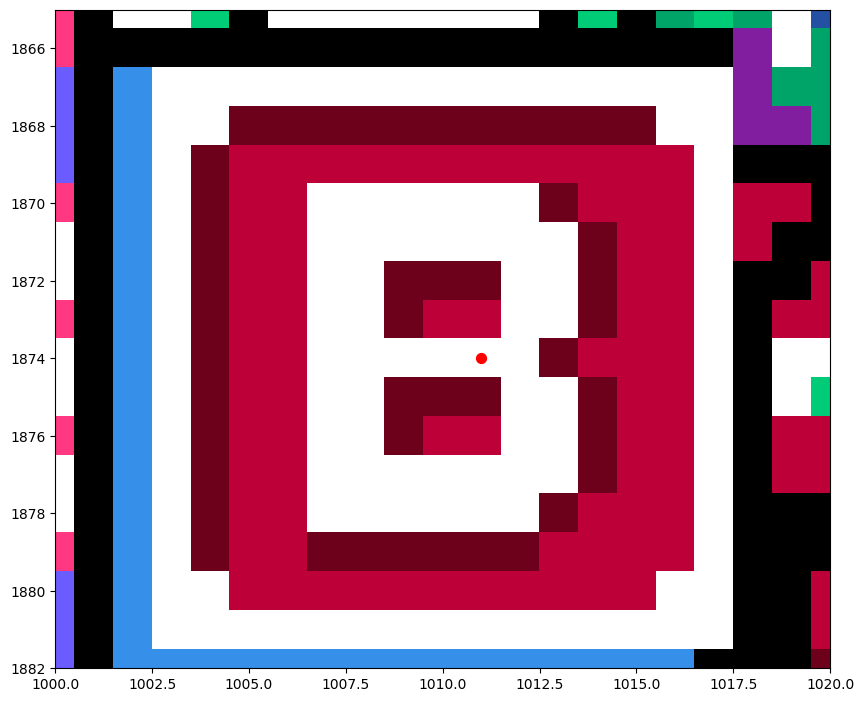

In [3]:
# b_emoji = [(1011, 1874)] # center of B emoji

# width, height = 1100, 2000 # zoom into these dim

# # create figure
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(final_canvas)

# # mark top pixels
# for (x, y) in b_emoji:
#     ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

# ax.set_xlim(1000, 1020)  # adjust 
# ax.set_ylim(1882, 1865)
# plt.show()

"The red B emoji 🅱️, Originally made to represent the blood type B but then it turned into a meme."

## anarchy chess

### board 1

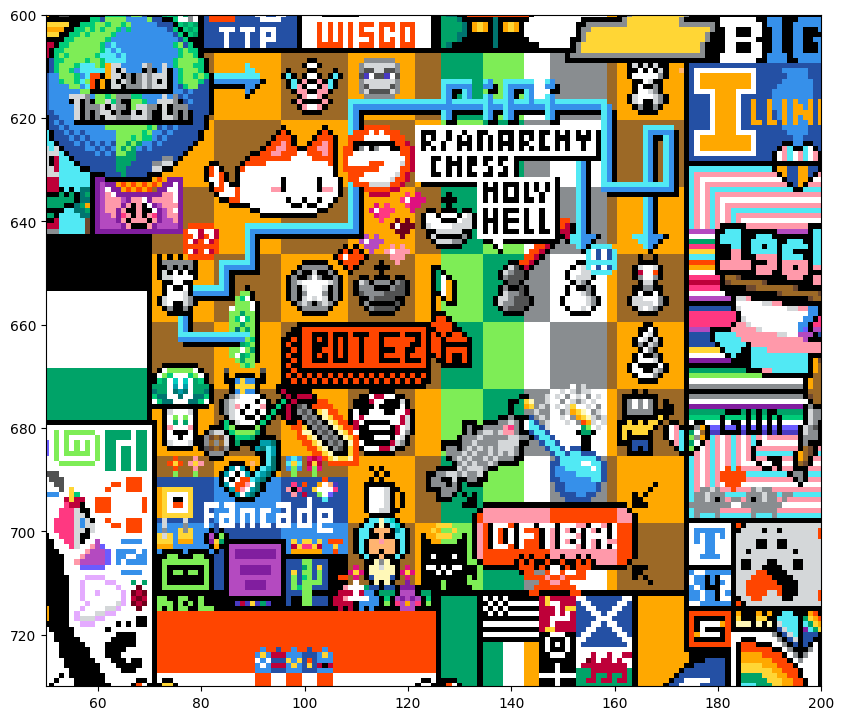

In [ ]:
board1 = [(124, 661)] # center of board1

width, height = 200, 730 # zoom into these dim

# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(final_canvas)

# mark top pixels
for (x, y) in board1:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(50, 200)  # adjust 
ax.set_ylim(730, 600)
plt.show()

### board 2

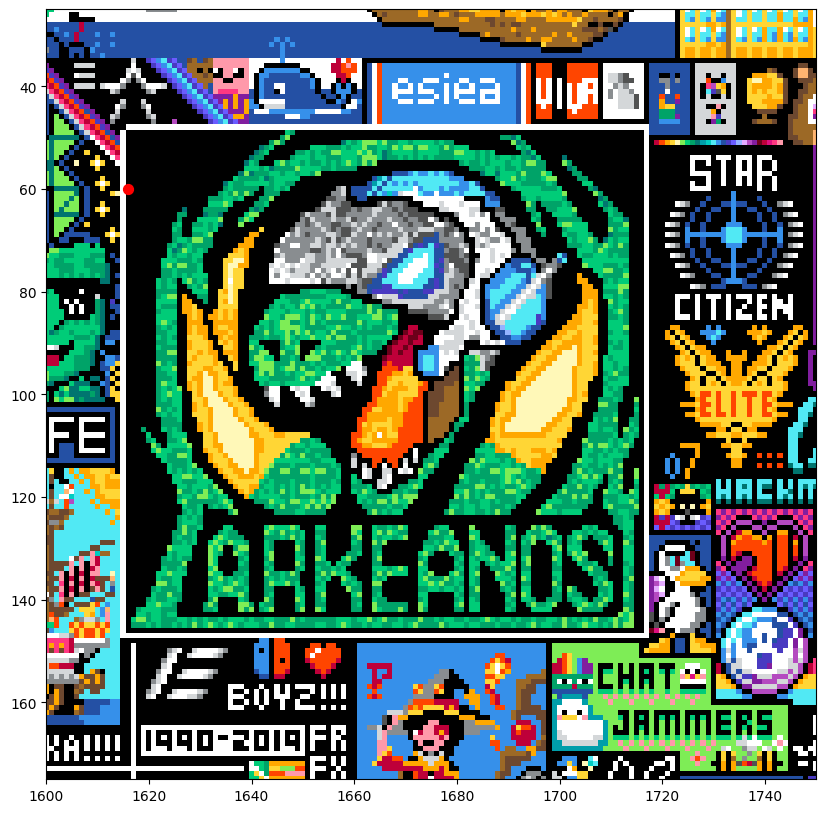

In [13]:
board2 = [(1616, 60)] # center of board

width, height = 2000, 100 # zoom into these dim

# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(final_canvas)

# mark top pixels
for (x, y) in board2:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(1600, 1750)  # adjust 
ax.set_ylim(175, 25)
plt.show()

In [82]:
# define board2 coordinate range
x_min, x_max = 1610, 1730
y_min, y_max = 40, 160

# get values for timelapse
df_board2 = (
    lf.filter(
        (pl.col("x") >= x_min) & (pl.col("x") <= x_max) &
        (pl.col("y") >= y_min) & (pl.col("y") <= y_max) & # filter thru dims
        (pl.col("timestamp") >= pl.lit("2022-04-02 16:30:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) # start time when board doubled
    )
    .with_columns(
        pl.col("timestamp").dt.truncate("30m").alias("time_bin")  # group into 30min bins
    )
    .group_by("time_bin", "x", "y")
    .agg(pl.col("pixel_color").last())  # Get the last pixel color per hour / get most common color
    .collect()
)

print(df_board2.shape)  # check final size
df_board2.head()  # Preview results

(150480, 4)


time_bin,x,y,pixel_color
datetime[μs],i64,i64,str
2022-04-03 17:30:00,1637,42,"""#FF4500"""
2022-04-04 23:30:00,1660,112,"""#FFFFFF"""
2022-04-03 10:30:00,1705,80,"""#9C6926"""
2022-04-04 11:00:00,1695,146,"""#B44AC0"""
2022-04-04 07:00:00,1688,44,"""#000000"""


Timelapse of Board 2

In [ ]:
# sort data by time_bin to process changes in chronological order
df_board2 = df_board2.sort("time_bin")

# get unique time bins (timestamps) in order
time_bins = df_board2["time_bin"].unique().sort()

# initialize a dictionary to store the last known color of each (x, y) pixel
pixel_state = {}  # Key = (x, y), Value = pixel_color

frames = []  # list to store images for the GIF

# process each timestamp
for time_bin in time_bins:
    df_snapshot = df_board2.filter(df_board2["time_bin"] == time_bin)

    # update pixel states with new colors
    for row in df_snapshot.iter_rows(named=True):
        x, y, color = row["x"], row["y"], row["pixel_color"]
        pixel_state[(x, y)] = color  # update last known color for this pixel

    # create a full frame with all known colors
    fig, ax = plt.subplots(figsize=(8, 8))

    # convert stored pixel colors into lists for plotting
    x_coords, y_coords, colors = zip(*[(x, y, color) for (x, y), color in pixel_state.items()])

    ax.scatter(x_coords, y_coords, c=colors, s=5, marker='s')  # scatter plot with stored pixel colors
    ax.invert_yaxis()
    ax.set_title(f"r/AnarchyChess Board 2 at {time_bin}")

    # render the plot to an image
    plt.draw()
    buf = fig.canvas.tostring_rgb()
    img = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(img)

    plt.close()  # close figure to avoid memory leaks

imageio.mimsave("board2_timelapse.gif", frames, duration=0.25)  # gif, 0.25s per frame

# saves previous pixel 

/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_52838/2442932173.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  buf = fig.canvas.tostring_rgb()


In [85]:
output_dir = "board2_frames" # directory to store images
os.makedirs(output_dir, exist_ok=True)

df_board2 = df_board2.sort("time_bin") # sort data by time_bin to process changes in chrono order
time_bins = df_board2["time_bin"].unique().sort() # unique timebins in order

# dictionary to store  last known color of each (x, y) pixel
pixel_state = {}  # Key = (x, y), Value = pixel_color

frames = []  # list to store images for GIF

# process each timestamp
for i, time_bin in enumerate(time_bins):
    df_snapshot = df_board2.filter(df_board2["time_bin"] == time_bin)

    # update pixel states with new colors
    for row in df_snapshot.iter_rows(named=True):
        x, y, color = row["x"], row["y"], row["pixel_color"]
        pixel_state[(x, y)] = color  # update last known color for this pixel

    fig, ax = plt.subplots(figsize=(8, 8)) # full frame 

    # convert stored pixel colors into lists for plotting
    if pixel_state:  # ensure there are pixels to plot
        x_coords, y_coords, colors = zip(*[(x, y, color) for (x, y), color in pixel_state.items()])
        ax.scatter(x_coords, y_coords, c=colors, s=5, marker='s')  # scatter plot with stored pixel colors

    ax.invert_yaxis()
    ax.set_title(f"r/AnarchyChess Board 2 at {time_bin}")

    frame_path = os.path.join(output_dir, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=300, bbox_inches='tight') # save frame

    plt.draw()
    buf = fig.canvas.tostring_rgb()
    img = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,)) # convert plot to img for GIF
    frames.append(img)

    plt.close()

imageio.mimsave("board2_timelapse.gif", frames, duration=0.25)  # gif, 0.25s per frame

/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_52838/187756655.py:37: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  buf = fig.canvas.tostring_rgb()
